
Language Modeling with nn.Transformer and TorchText
===============================================================

This is a tutorial on training a sequence-to-sequence model that uses the
`nn.Transformer <https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html>`__ module.

The PyTorch 1.2 release includes a standard transformer module based on the
paper `Attention is All You Need <https://arxiv.org/pdf/1706.03762.pdf>`

Compared to Recurrent Neural Networks (RNNs), the transformer model has proven
to be superior in quality for many sequence-to-sequence tasks while being more
parallelizable. The ``nn.Transformer`` module relies entirely on an attention
mechanism (implemented as `nn.MultiheadAttention <https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html>`
to draw global dependencies between input and output. The ``nn.Transformer``
module is highly modularized such that a single component (e.g.,
`nn.TransformerEncoder <https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html>` can be easily adapted/composed.

.. image:: ../_static/img/transformer_architecture.jpg


## Define the model

In this tutorial, we train a ``nn.TransformerEncoder`` model on a
language modeling task. The language modeling task is to assign a
probability for the likelihood of a given word (or a sequence of words)
to follow a sequence of words. A sequence of tokens are passed to the embedding
layer first, followed by a positional encoding layer to account for the order
of the word (see the next paragraph for more details). The
``nn.TransformerEncoder`` consists of multiple layers of
`nn.TransformerEncoderLayer <https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html>`__.
Along with the input sequence, a square attention mask is required because the
self-attention layers in ``nn.TransformerEncoder`` are only allowed to attend
the earlier positions in the sequence. For the language modeling task, any
tokens on the future positions should be masked. To produce a probability
distribution over output words, the output of the ``nn.TransformerEncoder``
model is passed through a linear layer followed by a log-softmax function.

In [1]:
import math, os
from typing import Tuple

# import copy
import time
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

In [2]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

``PositionalEncoding`` module injects some information about the
relative or absolute position of the tokens in the sequence. The
positional encodings have the same dimension as the embeddings so that
the two can be summed. Here, we use ``sine`` and ``cosine`` functions of
different frequencies.

In [3]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

## Load and batch data

In [4]:
######################################################################
# This tutorial uses ``torchtext`` to generate Wikitext-2 dataset.
# To access torchtext datasets, please install torchdata following instructions at https://github.com/pytorch/data. 
#
# UPDATE: using Wikitext-103, see https://blog.salesforceairesearch.com/the-wikitext-long-term-dependency-language-modeling-dataset/
# The vocab object is built based on the train dataset and is used to numericalize
# tokens into tensors. Wikitext-2 represents rare tokens as `<unk>`.
#
# Given a 1-D vector of sequential data, ``batchify()`` arranges the data
# into ``batch_size`` columns. If the data does not divide evenly into
# ``batch_size`` columns, then the data is trimmed to fit. For instance, with
# the alphabet as the data (total length of 26) and ``batch_size=4``, we would
# divide the alphabet into 4 sequences of length 6:
#
# .. math::
#   \begin{bmatrix}
#   \text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
#   \end{bmatrix}
#   \Rightarrow
#   \begin{bmatrix}
#   \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
#   \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
#   \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
#   \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
#   \end{bmatrix}
#
# Batching enables more parallelizable processing. However, batching means that
# the model treats each column independently; for example, the dependence of
# ``G`` and ``F`` can not be learned in the example above.
#

from torchtext.datasets import WikiText2, WikiText103
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# train_iter = WikiText2(split='train')
train_iter = WikiText103(split='train')
tokenizer  = get_tokenizer('basic_english')
vocab      = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>']) 

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# train_iter was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText103()
train_data_orig = data_process(train_iter)
val_data_orig   = data_process(val_iter)
test_data_orig  = data_process(test_iter)

In [5]:
prc = 0.01
train_data_sel = train_data_orig[:np.round(train_data_orig.shape[0]*prc).astype(np.int)]
train_data_sel.shape, train_data_orig.shape, val_data_orig.shape, test_data_orig.shape

(torch.Size([1015443]),
 torch.Size([101544324]),
 torch.Size([214572]),
 torch.Size([242042]))

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into bsz separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N]
        bsz: int, batch size

    Returns:
        Tensor of shape [N // bsz, bsz]
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

In [7]:
batch_size = 100
eval_batch_size = 100
train_data = batchify(train_data_sel, batch_size)  # shape [seq_len, batch_size]
val_data   = batchify(val_data_orig, eval_batch_size)
test_data  = batchify(test_data_orig, eval_batch_size)

In [8]:
train_data.shape, val_data.shape, test_data.shape

(torch.Size([10154, 100]), torch.Size([2145, 100]), torch.Size([2420, 100]))

## Functions to generate input and target sequence

In [9]:
######################################################################
# ``get_batch()`` generates a pair of input-target sequences for
# the transformer model. It subdivides the source data into chunks of
# length ``bptt``. For the language modeling task, the model needs the
# following words as ``Target``. For example, with a ``bptt`` value of 2,
# we’d get the following two Variables for ``i`` = 0:
#
# .. image:: ../_static/img/transformer_input_target.png
#
# It should be noted that the chunks are along dimension 0, consistent
# with the ``S`` dimension in the Transformer model. The batch dimension
# ``N`` is along dimension 1.
#

bptt = 35
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape [full_seq_len, batch_size]
        i: int

    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len * batch_size]
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

## Run the model


In [10]:
def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)

    num_batches = len(train_data) // bptt
    log_interval = 1000 # num_batches
    losses = []
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        batch_size = data.size(0)
        if batch_size != bptt:  # only on last batch
            src_mask = src_mask[:batch_size, :batch_size]
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()
        
    return losses

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            batch_size = data.size(0)
            if batch_size != bptt:
                src_mask = src_mask[:batch_size, :batch_size]
            output = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += batch_size * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

In [11]:
######################################################################
# The model hyperparameters are defined below. The vocab size is
# equal to the length of the vocab object.

ntokens = len(vocab)  # size of vocabulary
emsize  = 300  # embedding dimension
d_hid   = 300  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 3  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nheads  = 3  # number of heads in nn.MultiheadAttention
dropout = 0.0  # dropout probability
model   = TransformerModel(ntokens, emsize, nheads, d_hid, nlayers, dropout).to(device)

In [12]:
######################################################################
# Loop over epochs. Adjust the learning rate after each epoch.

criterion = nn.CrossEntropyLoss()
lr = 5  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
epochs    = 300

store_models = True
name = f'wikitext103-transformer-prc:{prc}'
models_dir = '/gstore/scratch/u/loukasa1/alg-stability' 
store_models_interval = 1

model_dir = f'{models_dir}/model_weights/{name}_{datetime.now().strftime("%d.%m.%Y-%H:%M:%S")}'
if not os.path.exists(model_dir): os.makedirs(model_dir)
print(model_dir)

losses_train, losses_val = [], []
for epoch in range(1, epochs + 1):
    
    epoch_start_time = time.time()
    
    losses_epoch = train(model)
    losses_train.extend(losses_epoch)
    
    val_loss = evaluate(model, val_data)
    val_ppl  = math.exp(val_loss)
    losses_val.append(val_loss)
    
    elapsed = time.time() - epoch_start_time
    print(f' {epoch:3d} | time: {elapsed:5.2f}s | train loss {np.mean(losses_epoch):5.2f} | ' + 
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')

    if epoch < 10: scheduler.step()
        
    if store_models and epoch % store_models_interval == 0:
        torch.save({'epoch': epoch, 
                    'transformer_encoder.layers.0.linear1.weight': model.state_dict()['transformer_encoder.layers.0.linear1.weight'], 
                    'loss': np.mean(losses_epoch), 
                    'loss_val': val_loss, 
                    'loss_test': evaluate(model, test_data)}, model_dir + f'/state_{epoch}.pt')

/gstore/scratch/u/loukasa1/alg-stability/model_weights/wikitext103-transformer-prc:0.01_29.04.2022-12:01:24
   1 | time: 57.21s | train loss  9.91 | valid loss  8.33 | valid ppl  4130.84
   2 | time: 57.37s | train loss  7.74 | valid loss  7.27 | valid ppl  1442.79
   3 | time: 57.44s | train loss  6.95 | valid loss  6.80 | valid ppl   894.83
   4 | time: 57.46s | train loss  6.46 | valid loss  6.61 | valid ppl   740.15
   5 | time: 57.45s | train loss  6.09 | valid loss  6.50 | valid ppl   662.09
   6 | time: 57.51s | train loss  5.76 | valid loss  6.41 | valid ppl   605.33
   7 | time: 57.51s | train loss  5.47 | valid loss  6.41 | valid ppl   607.15
   8 | time: 57.54s | train loss  5.19 | valid loss  6.43 | valid ppl   621.61
   9 | time: 57.57s | train loss  4.92 | valid loss  6.55 | valid ppl   696.98
  10 | time: 57.58s | train loss  4.66 | valid loss  6.64 | valid ppl   766.46
  11 | time: 57.61s | train loss  4.44 | valid loss  6.84 | valid ppl   932.34
  12 | time: 57.65s | t

## Evaluate the last model on the test dataset

In [13]:
test_loss = evaluate(model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss 17.50 | test ppl 39918036.16


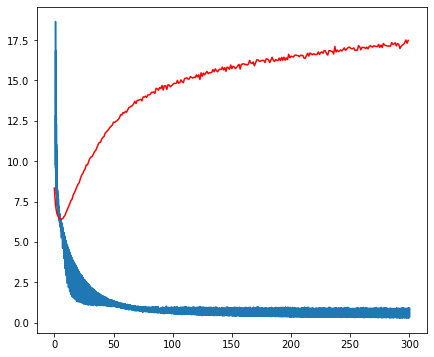

In [14]:
fig = plt.figure(figsize=(7, 6), facecolor=(1,1,1))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(1, epoch, len(losses_train)), losses_train)
ax.plot(losses_val, 'r-')
# ax.set_yscale('log')